#### Objective

In this notebook I am testing a reduced workflow that will:

1) take one of the nonperceptual colormaps from matplotlib library (spectral)

2) convert from RGB to Lab to get the lightness profile

3) show that the lightness profile has non uniform gradient

4) equalize it by rendering the gradient uniform (in absolute value)

5) convert back to RGB to make an equalized spectral colormap

##### NB there is an alternative apporache for creating a perceptual version of a colormap that is not based on equalzation of the lightness contrast. 

##### It involves working in HLC colour space and determining the hue range of the colormap, and fitting a lightness profile that linearly changes between 0 - 100 as the hue changes between its minimum and maximum value; the chroma c would be kept constant. 

##### This method will be demonstrated in a separate notebook.

#### Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as clr
import matplotlib.cm as cm

#### Get spectral colormap, convert from RGB to Lab, plot lightness profile

This part is taken (with a few modifications) from my tutorial Evaluate and compare colormaps:
https://github.com/seg/tutorials/blob/master/1408_Evaluate_and_compare_colormaps/How_to_evaluate_and_compare_colormaps.ipynb

To get lightness we need to convert the colormaps from RGB values to CIE Lab values. The function rgb2lab from the Scikit-image image processing toolbox does just that. However, before we can utilize the function we'll need to convert each 256 x 3 RGB array into a 256 x 256 x 3 array because the library was written for RGB images (sometimes called truecolor images; you can think of these as images of M x N size with each of the three RGB channels stored in a separate element of the 3rd dimension of the array). 

First, we get the 256 RGB values.

In [2]:
sp=np.arange(256)
my_spectral = cm.get_cmap('spectral') 
normsp = clr.Normalize(0, 256) 
colsp = my_spectral(normsp(sp))

Next we use the tile Numpy function to replicate 120 times the 1 x 120 red, green, and blue arrays.

In [3]:
rsp = np.tile(colsp[:,0], (256,1))
gsp = np.tile(colsp[:,1], (256,1))
bsp = np.tile(colsp[:,2], (256,1))

rsp.shape # check the shape of the output array

(256, 256)

Next we zip the three arrays above together

In [4]:
rgb_sp=np.array(zip(rsp, gsp ,bsp))

rgb_sp.shape # check the shape of the output array

(256, 3, 256)

Oops! The result seems correct but the last two dimensions are in the wrong order. The Numpy swapaxes function will fix that.

In [5]:
rgb_spectral=np.swapaxes(rgb_sp,1,2)

rgb_spectral.shape # check the shape of the array again

(256, 256, 3)

Done! But to be 100% sure let's plot the image with the next block of code.

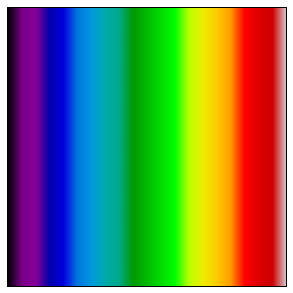

In [6]:
fig8 = plt.figure(figsize=(5,5))
ax8 = fig8.add_subplot(1, 1, 1)

ax8.set_xticks([])
ax8.set_yticks([])

plt.imshow(rgb_spectral)

Perfect. This is a 256 rows by 256 columns image in which each row is a 256-sample spectral palette. Now we are ready to convert it to CIE Lab.

In [7]:
import skimage.color as skl
lab_sp = skl.rgb2lab(rgb_spectral)

#### Creating the lightness profile for the spectral colormap

Below we extract the lightness 1 x 256 array (1st row, all columns, 1st channel - remember again that Python starts indexing at 0).

In [8]:
l_sp = lab_sp[0,:,0]

l_sp.shape # check the shape

(256,)

We can also plot it to make sure it makes sense.

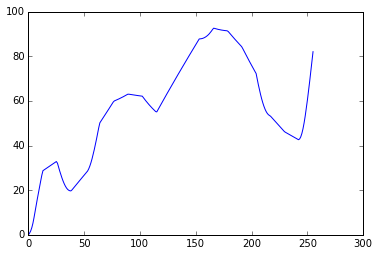

In [9]:
plt.plot(l_sp)

It does in that the values of lightness are within the 0-100 range, as they should be, but it certainly looks very erratic.

I will make this plot a bit nicer using the colorline function by David Sanders (dpsanders on GitHub), which you can find in this notebook:

http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb

In [10]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

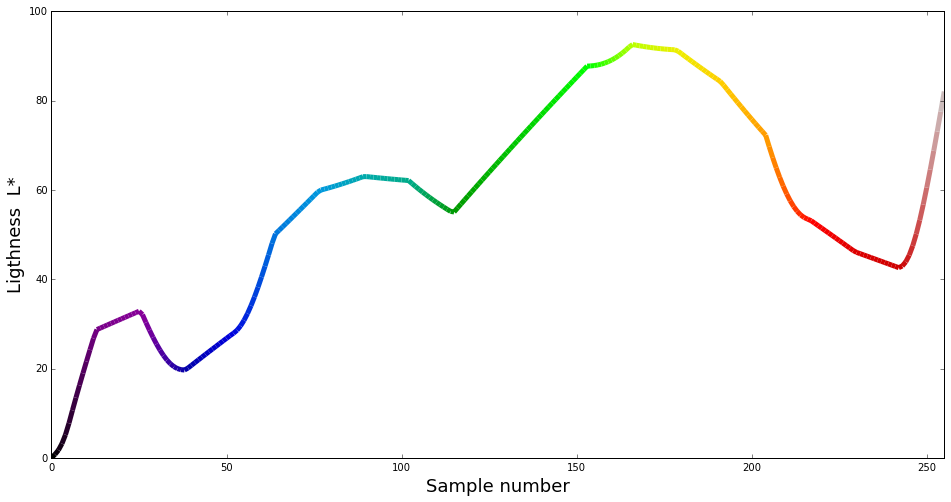

In [12]:
xsp = np.arange(256)
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 1, 1)
colorline(xsp,l_sp,linewidth=5,cmap="spectral")
ax.set_ylabel('Ligthness  L*', fontsize = '18' )
ax.set_xlabel('Sample number', fontsize = '18')
plt.xlim(xsp.min(), xsp.max())
plt.ylim(0, 100)

plt.show()


Now for each sample in the original colormap (x coordinate is the sample number) we have its unique lightness value (y coordinate) and colour.

The erratic lightness profile in the figure above highlights the many issues with spectral. The curve gradient changes magnitude several times, indicating a nonuniform perceptual distance between samples, and also its sign.

##### Equalizing the  lightness contrast for the spectral colormap

I tried before, using Matlab, to equalize a spectral colormap by dynamically stretching (resampling) it so as to make it more uniformly perceptual. 

You can read about that effort in the third post of my blog series The rainbow is dead ... log live the rainbow:
https://mycarta.wordpress.com/2012/10/06/the-rainbow-is-deadlong-live-the-rainbow-part-3/

You can see an example of the Matlab code applied to the Jet colormap in the figure below.

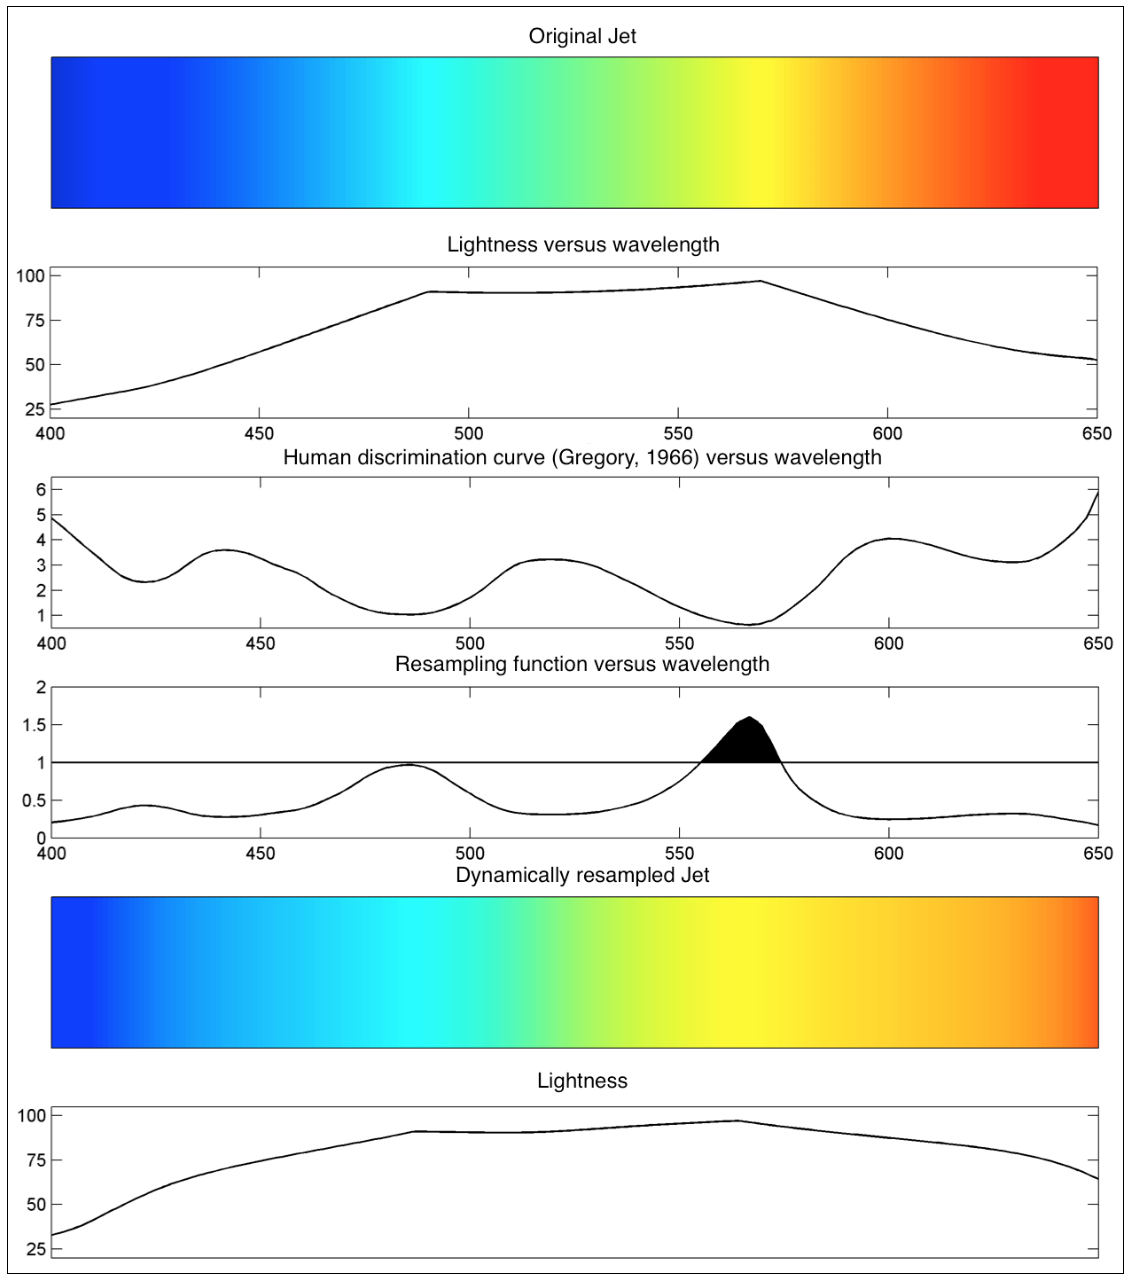

In [13]:
from skimage import io
stretch = io.imread('stuff4equalize_notebook/Equalize_Jet_Matlab.png')

fig = plt.figure(figsize=(20, 26))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(stretch)
plt.show()

My logic in putting together this method was as such:

First, take the human discrimination curve (from Gregory’s 1966 book Eye and Brain, which compares wavelength of light with the smallest  difference in hue, as wavelength difference, observable by the human eye. This curve, which I called _**DeltaP**_, is shown in the third subplot above.

Second, invert the curve as _**DeltaPinv = 1/DeltaP**_. 

Next, sum it up as _**S = sum(DeltaPinv)**_ and from that, calculate the 'resampling function', shown in the forth subplot, as _**RF = cumsum(DeltaPinv)/S*255**_. 

FInally, use the 'resampling function' as a continuously varying sample rate to stretch the Jet colormap, like this:

> for i = 1:3

>      newJet(:,i) = interp1(RF, Jet(:,1), [0:1:255])

> end


The plot below is a good visual illustration of the lightnes profile before and after the dynamic resampling. The distance between vertical lines is equivalent to sample rate in the colormap. Areas of low lightness gradient are sampled more densely than areas with high lightness gradient in the input colormap, resulting in a uniform sample rate in the stretched colormap.

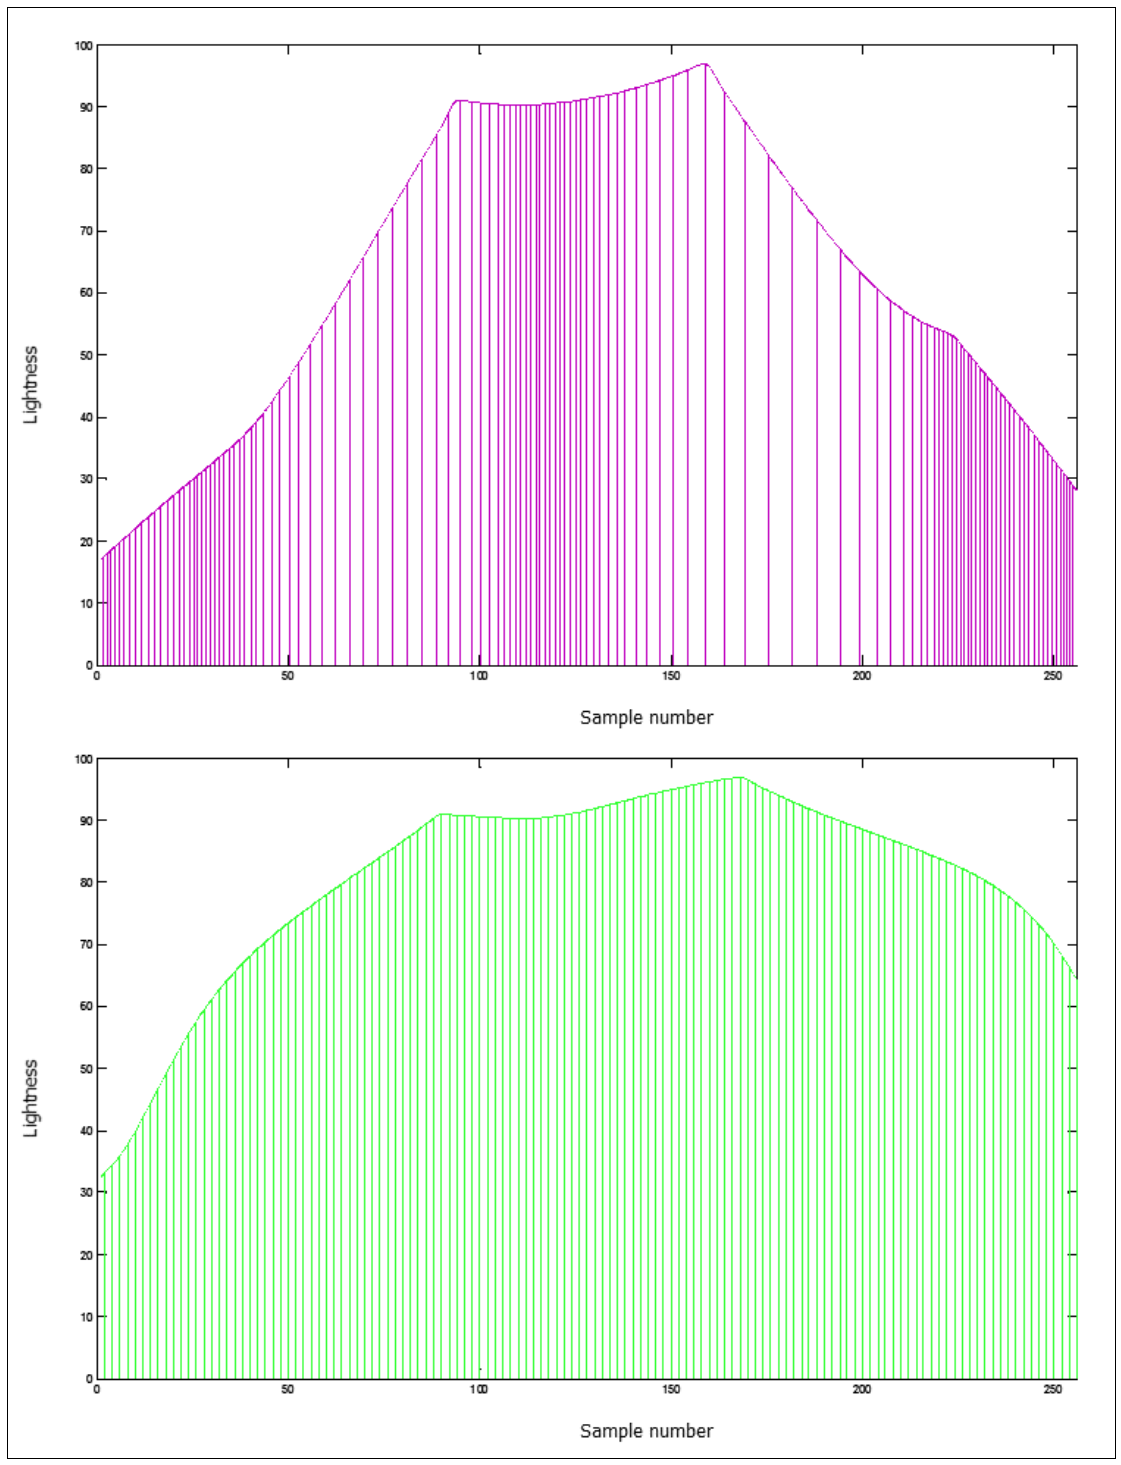

In [14]:
stem = io.imread('stuff4equalize_notebook/Final_stem_plots.png')

fig = plt.figure(figsize=(20, 26))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(stem)
plt.show()

I think I was on the right track with this idea, but in the end the results of my initial approach were poor for two reasons:

1) instead of deriving a correction curve using the lightness profile itself, I used the human discrimination curve, and 

2) I applied the correction th the R, G, and B channels instead of the lightness.

After those mixed results, I moved on and concentrated on creating perceptual colormaps from scratch.

However, I discovered last year that Peter Kovesi, from the Geophysics and Image Analysis Group  at the University of Western Australia, had perfected an equalization technique (based on work by Pizer):
http://peterkovesi.com/projects/colourmaps/ColourmapTheory/index.html
Peter published this year a fantastic paper, which I highly recommend reading:
Good Colour Maps - How to Design Them http://arxiv.org/abs/1509.03700

This is my implementation, based in part on Peter's Matlab function, equalisecolormap.m, which can be found at:
http://www.peterkovesi.com/matlabfns/#colour, 
and in part on my Matlab code from the aforementioned experiment.

We start by first calculating the sample-to-sample perceptual differences (as differences in lightness contrast).

In [15]:
x = np.linspace(0,257,256) # we resample to 257 samples so as to have 256 differences
xnew = np.arange(257)
l257 = np.interp(xnew, x, l_sp)

deltaL = np.sqrt(np.square(l257[1:] - l257[:-1]))

Secondly, we calculate the cumulative lighteness contrast differences.

In [16]:
cumdeltaL = np.cumsum(deltaL)

We use the minimum and maximum in the cumulative lighteness contrast differences to divide it into 256 equispaced values.

In [17]:
kcumdeltaL = np.linspace(min(cumdeltaL), max(cumdeltaL), 256)

Those values are then used to interpolate for the new sample locations necessary to make the gradient of the cumulative lighteness contrast differences constant, and the new sample locations in turn are used to interpolate for the new lightness values.

In [18]:
newN = np.interp(kcumdeltaL, cumdeltaL, np.arange(256))
newL = np.interp(newN, np.arange(256), l_sp)

The process is illustrated visually in the figure below.

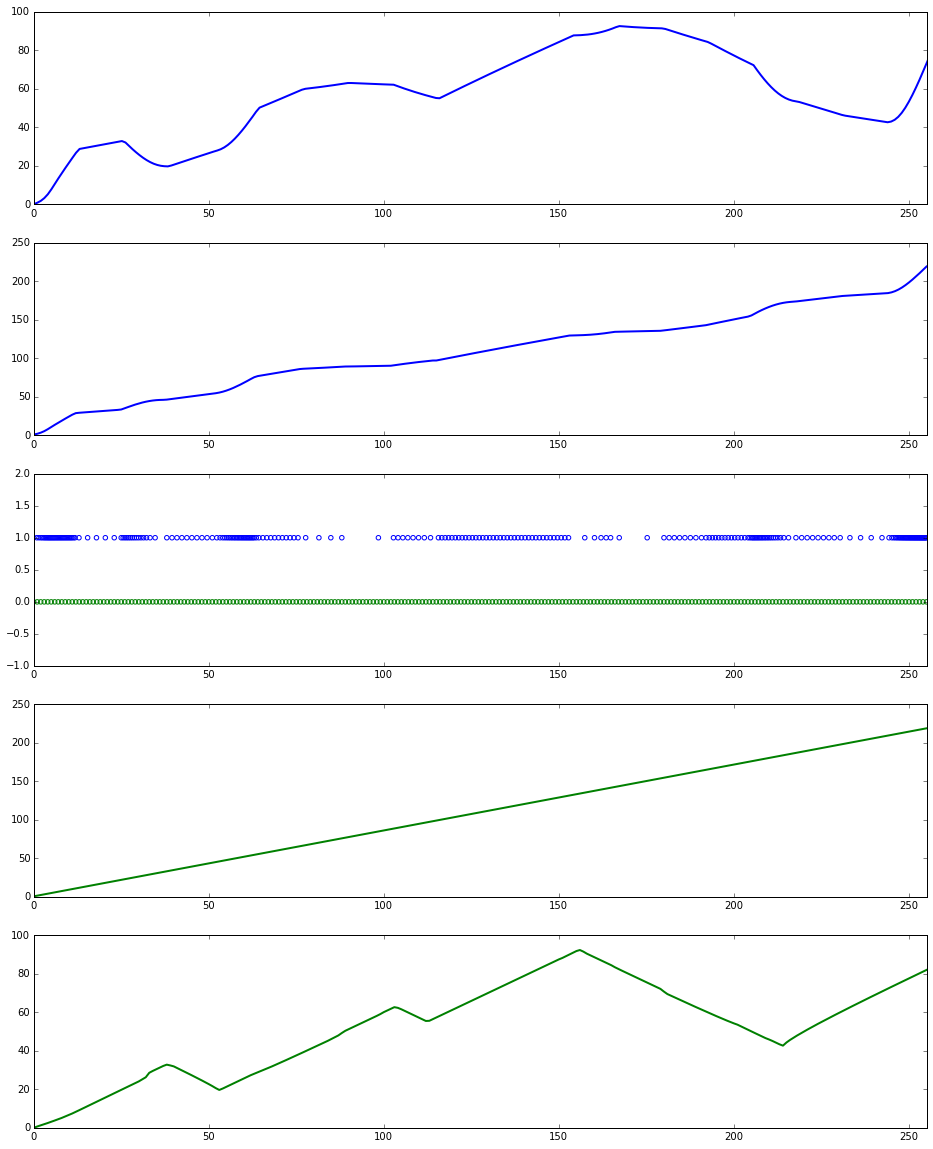

In [19]:
fig = plt.figure(figsize=(16,20))

ax0 = plt.subplot2grid((5,1), (0,0))
ax0.plot(x, l_sp, lw=2)
ax0.set_xlim([0, 255])

ax1 = plt.subplot2grid((5,1), (1,0))
x = np.arange(256)
ax1.plot(x, cumdeltaL, lw=2)
ax1.set_xlim([0, 255])

ax2 = plt.subplot2grid((5,1), (2,0))
ax2.scatter(newN, np.ones(256), s = 20, facecolors='none', edgecolors='b')
ax2.scatter(np.arange(256), np.zeros(256), s = 20, facecolors='none', edgecolors='g')
ax2.set_xlim([0, 255])
ax2.set_ylim([-1, 2])

ax3 = plt.subplot2grid((5,1), (3,0))
ax3.plot(x, kcumdeltaL, 'g', lw=2)
ax3.set_xlim([0, 255])

ax4 = plt.subplot2grid((5,1), (4,0))
ax4.plot(x, newL, 'g', lw=2)
ax4.set_xlim([0, 255])

plt.show()

In [20]:
lab = np.array(zip(newL, lab_sp[0,:,1], lab_sp[0,:,2]))

In [21]:
l_ = np.tile(lab[:,0],(256,1))
a_ = np.tile(lab[:,1],(256,1))
b_ = np.tile(lab[:,2],(256,1))
lab_=np.array(zip(l_, a_ ,b_))
lab_=np.swapaxes(lab_,1,2)
lab_.shape

(256, 256, 3)

In [22]:
rgb = skl.lab2rgb(lab_)
rgb.shape

(256, 256, 3)

In [23]:
rgb = rgb[0,:,:]
rgb.shape

(256, 3)

In [24]:
b03=rgb[:,2] # value of blue at sample n
b02=rgb[:,2] # value of blue at sample n
b01=np.linspace(0,1,len(b02)) # position of sample n - ranges from 0 to 1

g03=rgb[:,1] 
g02=rgb[:,1]
g01=np.linspace(0,1,len(g02))

r03=rgb[:,0] 
r02=rgb[:,0]
r01=np.linspace(0,1,len(r02))

# creating lists
r=zip(r01,r02,r03)
g=zip(g01,g02,g03)
b=zip(b01,b02,b03)

# transposing
rgb_=zip(r,g,b)
rgb=zip(*rgb_)
#print rgb

#creating dictionary
k=['red', 'green', 'blue'] 
rgb1=dict(zip(k,rgb)) # makes a dictionary from 2 lists
my_rgb = clr.LinearSegmentedColormap('my_colormap',rgb1)

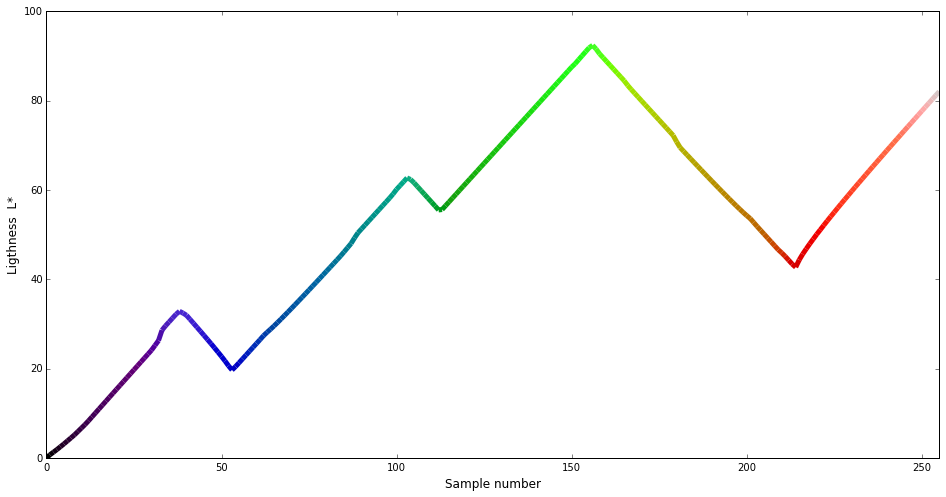

In [25]:
xsp = np.arange(256)
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 1, 1)
colorline(xsp,newL,linewidth=5,cmap=my_rgb)
ax.set_ylabel('Ligthness  L*', fontsize = '12' )
ax.set_xlabel('Sample number', fontsize = '12')
plt.xlim(xsp.min(), xsp.max())
plt.ylim(0, 100)


plt.show()
#fig.savefig('L_profile_spectral.png', dpi=200)

#### Comparison of palettes with real data - Penobscot 3D horizon

Penobscot 3D horizon used by Matt Hall (Hall, 2014)

In [26]:
data = np.loadtxt('stuff4equalize_notebook/Penobscot_HorB.txt')
inlines = 1597 - 1003 + 1
xlines = 1471 - 1009 + 1

data[:,0] = inlines - (data[:,0] - 1002) 
data[:,1] -= 1008 # same as data[:,1] = data[:,1] - 1008

In [27]:
horizon = np.empty((inlines, xlines))

for sample in data:
    inline = sample[0]
    xline = sample[1]
    z_value = sample[2]
    
    # We have to subtract 1 to allow for 0-based indexing
    horizon[inline - 1, xline - 1] = z_value

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


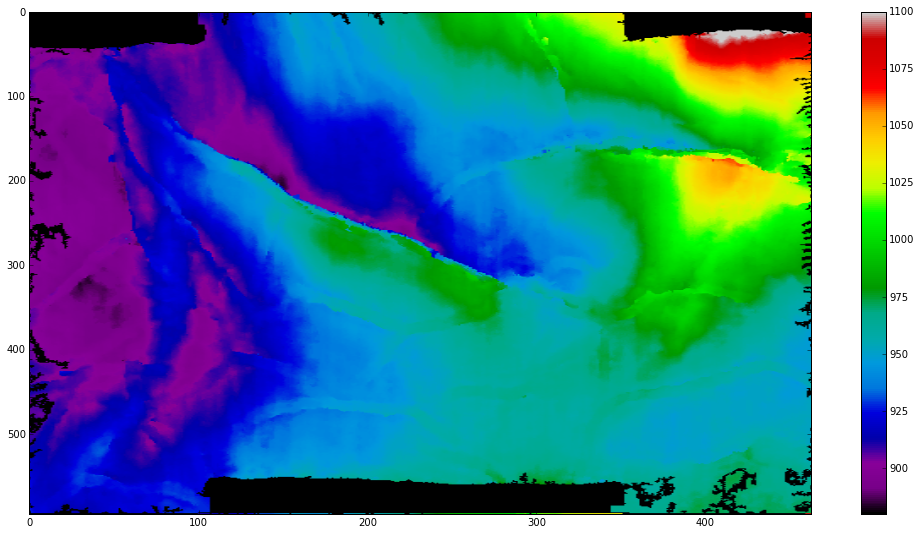

In [28]:
fig13 = plt.figure(figsize=(18,9))
plt.imshow(horizon, aspect=0.5, vmin=880, vmax=1100, cmap='spectral') 
plt.colorbar()
plt.show()

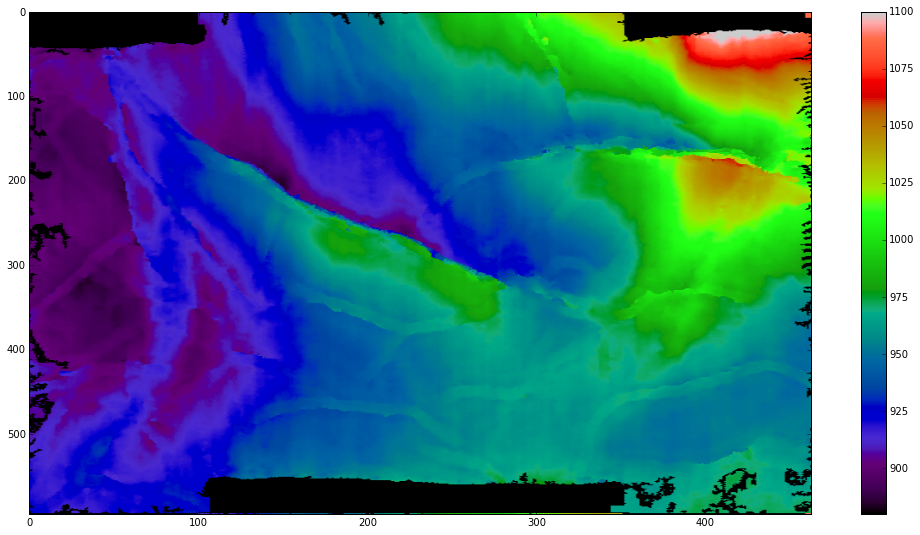

In [29]:
fig = plt.figure(figsize=(18,9))
plt.imshow(horizon, aspect=0.5, vmin=880, vmax=1100, cmap=my_rgb)
plt.colorbar()
plt.show()

### SUCCESS !

#### Possible things to try next

Apply equalization recursively as Peter Kovesi suggests.

Apply as full 3D Lightness equalization with 3D CIELab plots of colormap. Or CAM02-UCS color space as in viscm: https://bids.github.io/colormap/

Smoothing at the lightness sign changes as Peter Kovesi suggests?

#### References

Gregory, R.L. (1966) Eye and Brain: The Psychology of Seeing. Princeton Science Library.
http://press.princeton.edu/titles/6141.html

Hall, M. (2014) Smoothing surfaces and attributes. The Leading Edge 33, no. 2, 128–129, http://dx.doi.org/10.1190/tle33020128.1

Kovesi, P. (2015) Good Colour Maps: How to Design Them. eprint arXiv:1509.03700, http://arxiv.org/abs/1509.03700

Pizer, S. (1981) Intensity mappings to linearize display devices. Computer Graphics and Image Processing, vol. 17, no. 3, pp. 262-268